In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import wandb

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.utils import data


import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import functools
from tqdm import tqdm
from datetime import datetime
import numpy as np
from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator
from einops import rearrange, reduce, pack, unpack


In [4]:
# import torch
# from torch.utils import data
# import numpy as np
# from os.path import join as pjoin
# import random
# import codecs as cs
# from tqdm import tqdm



# class VQMotionDataset(data.Dataset):
#     def __init__(self, dataset_name, window_size = 64, unit_length = 4):
#         self.window_size = window_size
#         self.unit_length = unit_length
#         self.dataset_name = dataset_name

#         if dataset_name == 't2m':
#             self.data_root = '/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D'
#             self.motion_dir = pjoin(self.data_root, 'new_joint_vecs')
#             self.text_dir = pjoin(self.data_root, 'texts')
#             self.joints_num = 22
#             self.max_motion_length = 196
#             self.meta_dir = ''

#         elif dataset_name == 'kit':
#             self.data_root = './dataset/KIT-ML'
#             self.motion_dir = pjoin(self.data_root, 'new_joint_vecs')
#             self.text_dir = pjoin(self.data_root, 'texts')
#             self.joints_num = 21

#             self.max_motion_length = 196
#             self.meta_dir = 'checkpoints/kit/VQVAEV3_CB1024_CMT_H1024_NRES3/meta'
        
#         joints_num = self.joints_num

#         mean = np.load(pjoin(self.data_root, 'Mean.npy'))
#         std = np.load(pjoin(self.data_root, 'Std.npy'))

#         split_file = pjoin(self.data_root, 'val.txt')

#         self.data = []
#         self.lengths = []
#         id_list = []
#         with cs.open(split_file, 'r') as f:
#             for line in f.readlines():
#                 id_list.append(line.strip())

#         for name in tqdm(id_list):
#             try:
#                 motion = np.load(pjoin(self.motion_dir, name + '.npy'))
#                 if motion.shape[0] < self.window_size:
#                     continue
#                 self.lengths.append(motion.shape[0] - self.window_size)
#                 self.data.append(motion)
#             except:
#                 # Some motion may not exist in KIT dataset
#                 pass

            
#         self.mean = mean
#         self.std = std
#         print("Total number of motions {}".format(len(self.data)))

#     def inv_transform(self, data):
#         return data * self.std + self.mean
    
#     def compute_sampling_prob(self) : 
        
#         prob = np.array(self.lengths, dtype=np.float32)
#         prob /= np.sum(prob)
#         return prob
    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, item):
#         motion = self.data[item]
        
#         idx = random.randint(0, len(motion) - self.window_size)

#         motion = motion[idx:idx+self.window_size]
#         "Z Normalization"
#         motion = (motion - self.mean) / self.std

#         return motion

In [523]:
trainSet = VQMotionDataset("aist", data_root="/srv/scratch/sanisetty3/music_motion/AIST")

100%|██████████| 952/952 [00:54<00:00, 17.47it/s]

Total number of motions 951


In [24]:
def DATALoader(
            dataset,
            batch_size,
            num_workers = 0,
            shuffle = True,
           ):
    train_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size,
                                                shuffle=shuffle,
                                                #sampler=sampler,
                                                num_workers=num_workers,
                                                #collate_fn=collate_fn,
                                                drop_last = True)

    return train_loader

In [25]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [53]:
train_loader = DATALoader(trainSet , 2)
train_loader_iter = cycle(train_loader)

In [54]:
gt_motion = next(train_loader_iter)

In [55]:
gt_motion.shape

torch.Size([2, 40, 263])

In [29]:
from core.models.vqvae import VQMotionModel
from core.models.loss import ReConsLoss


In [30]:
loss_fnc = ReConsLoss("l2", 22)

In [31]:
model = VQMotionModel()

VectorQuantize(
  (project_in): Identity()
  (project_out): Identity()
  (_codebook): EuclideanCodebook()
)

In [32]:
pred_motion , indices, commit_loss = model(gt_motion)

In [33]:
loss_motion = loss_fnc(pred_motion, gt_motion)


In [23]:
loss_vel = loss_fnc.forward_vel(pred_motion, gt_motion)

In [47]:
from utils.motion_process import recover_from_ric
import visualize.plot_3d_global as plot_3d
from glob import glob
def to_xyz(motion):
    motion_xyz = recover_from_ric(motion.cpu().float()*train_ds.std+train_ds.mean, 22)
    motion_xyz = motion_xyz.reshape(motion.shape[0],-1, 22, 3)
    return motion_xyz

            
def sample_render(motion_xyz , name , save_path):
    print(f"render start")
    
    gt_pose_vis = plot_3d.draw_to_batch(motion_xyz.numpy(),None, [os.path.join(save_path,name + ".gif")])



In [37]:
gt_motion.shape

torch.Size([8, 60, 263])

In [40]:
sample_render(to_xyz(pred_motion[0:1].detach().cpu()), "aist0_pred" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals")

render start


## Variable motion lengths


In [5]:
import torch
from torch.utils import data
import numpy as np
from os.path import join as pjoin
import random
import codecs as cs
from tqdm import tqdm

In [330]:

class MotionCollator():
    def __init__(self, max_seq_length):
        self.max_seq_length = max_seq_length
        self.bos = torch.LongTensor(([0]))
        self.eos = torch.LongTensor(([2]))
        self.pad = torch.LongTensor(([1]))

    def __call__(self, samples):
        

        pad_batch_inputs = []
        pad_batch_mask = []
        motion_lengths = []
        names = []
        max_len = max([sample.shape[0] for sample, name in samples])


        for inp,name in samples:
            n,d = inp.shape
            diff = max_len - n
            mask = torch.BoolTensor([1]*n + [0]*diff)
            padded = torch.concatenate((torch.tensor(inp) , torch.ones((diff,d))*self.pad))
            pad_batch_inputs.append(padded)
            pad_batch_mask.append(mask)
            motion_lengths.append(n)
            names.append(name)

    
        batch = {
            "motion": torch.stack(pad_batch_inputs , 0),
            "motion_length": torch.Tensor(motion_lengths),
            "motion_mask" : torch.stack(pad_batch_mask , 0),
            "names" : np.array(names)

        }

   
        return batch    
    

In [6]:
from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator
from core.datasets import vqa_motion_dataset

In [7]:
# train_ds = vqa_motion_dataset.VQMotionDataset("t2m",split = "render", data_root = "/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D")


100%|██████████| 10/10 [00:00<00:00, 864.13it/s]

Total number of motions 8


In [32]:
train_ds = VQVarLenMotionDataset("t2m", split = "render" , data_root = "/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D")


changing range to: 60 - 60


100%|██████████| 10/10 [00:00<00:00, 23.32it/s]

Total number of motions 8


In [33]:
collate_fn = MotionCollator(200)

In [34]:
train_ds = VQVarLenMotionDataset("t2m", split = "render" , data_root = "/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D")
collate_fn = MotionCollator(200)
train_loader = DATALoader(train_ds,
                                                4,
                                                #sampler=sampler,
                                                collate_fn=collate_fn,
                                                )

In [35]:
train_loader.batch_size

4

In [36]:
for batch in train_loader:
    break

In [49]:
gt_motion = batch["motion"]
print(gt_motion.shape)
print(batch["motion_lengths"])

torch.Size([4, 92, 263])
tensor([81., 82., 68., 92.])


In [50]:
train_loader.dataset.set_stage(3)

changing range to: 60 - 140


In [118]:
motion_len = int(batch.get("motion_lengths" , [gt_motion.shape[1]])[0])

In [119]:
gt_motion[:,:motion_len,:].shape

torch.Size([1, 97, 263])

In [17]:
batch["motion"].shape

torch.Size([4, 192, 263])

In [43]:
from core.models.vqvae import MotionTransformer, MotionDecoder, LinearEmbedding, VQMotionModel
from core.quantization.core_vq import VectorQuantization
from x_transformers.x_transformers import AttentionLayers, Encoder, Decoder, exists, default, always,ScaledSinusoidalEmbedding,AbsolutePositionalEmbedding, l2norm
from core.models.loss import ReConsLoss


In [39]:
from configs.config import cfg
model = VQMotionModel(cfg.vqvae).cuda()

In [37]:
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total training params: %.2fM" % (total / 1e6))

Total training params: 151.57M


In [40]:
pred_motion , indices, commit_loss = model(batch["motion"].cuda() , mask = batch["motion_mask"].cuda())

/coc/scratch/sanisetty3/music_motion/motion_vqvae/core/quantization/core_vq.py:375: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


In [41]:
pred_motion.shape

torch.Size([4, 192, 263])

In [44]:
loss_fnc = ReConsLoss("l1", 22)

In [45]:
loss_fnc(pred_motion, batch["motion"].cuda() ,  batch["motion_mask"].cuda())

tensor(1.1719, device='cuda:0', grad_fn=<MulBackward0>)

In [47]:
loss_fnc.forward_vel(pred_motion, batch["motion"].cuda() ,  batch["motion_mask"].cuda())

tensor(0.2821, device='cuda:0', grad_fn=<MulBackward0>)

In [338]:
motionEncoder = MotionTransformer(
        inp_dim =263,
        max_seq_len = 200,
        scaled_sinu_pos_emb = True,
        attn_layers = Encoder(
            dim = 768,
            depth = 2,
            heads = 4,

        )
    )

In [345]:
encoded_motion = motionEncoder(batch["motion"] , mask = batch["motion_mask"])
print(encoded_motion.shape)

torch.Size([4, 107, 768])


In [347]:
vq = VectorQuantization(
        dim = 768,
        codebook_dim = 128,
        codebook_size = 1024,
        decay = 0.95,
        commitment_weight = 1,
        kmeans_init = True,
        threshold_ema_dead_code = 2,
)

In [348]:
quantized_enc_motion, indices, commit_loss = vq(encoded_motion)
print(quantized_enc_motion.shape)

torch.Size([4, 107, 768])


/coc/scratch/sanisetty3/music_motion/motion_vqvae/core/quantization/core_vq.py:350: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


In [358]:
embed = vq.codebook.t()
embed.pow(2).sum(0, keepdim=True).shape

torch.Size([1, 1024])

In [410]:
x = encoded_motion[:,:,:128]
shape = x.shape

In [411]:
x = rearrange(x, "... d -> (...) d")
x

tensor([[-0.3801,  0.7024,  1.5966,  ...,  0.7535, -1.5004, -0.4283],
        [-0.2908,  0.5800,  1.6096,  ...,  0.4755, -1.5223, -0.3614],
        [-0.2561,  0.4115,  1.5109,  ...,  0.1626, -1.4867, -0.2438],
        ...,
        [ 0.5579,  0.1785,  0.0483,  ..., -0.8444, -0.6883,  1.2005],
        [ 0.5358,  0.1656,  0.1023,  ..., -0.8245, -0.6591,  1.2180],
        [ 0.5378,  0.0897,  0.1818,  ..., -0.8273, -0.6676,  1.2187]],
       grad_fn=<ReshapeAliasBackward0>)

In [412]:
dist = -(
    x.pow(2).sum(1, keepdim=True)
    - 2 * x @ embed
    + embed.pow(2).sum(0, keepdim=True)
)


In [413]:
dist.shape

torch.Size([428, 1024])

In [414]:
embed_ind = dist.max(dim=-1).indices

In [415]:
embed_ind.shape

torch.Size([428])

In [416]:
inp_mask = rearrange(batch["motion_mask"], "... -> (...)")
inp_mask.shape


torch.Size([428])

In [417]:
mask_value = -torch.finfo(dist.dtype).max

In [440]:
dist[106]

tensor([-1.6291e+02, -1.6781e+02, -1.2629e+02,  ..., -3.8359e+11,
        -3.0852e+11, -4.7003e+11], grad_fn=<SelectBackward0>)

In [418]:
dist2 = (dist + dist.masked_fill(~inp_mask[...,None] , mask_value))

In [419]:
embed_ind2 = dist2.max(dim=-1).indices

In [435]:
embed_ind2[105]

tensor(0)

In [436]:
embed_onehot = F.one_hot(embed_ind2, 1024)

In [424]:
embed_ind = vq._codebook.postprocess_emb(embed_ind, shape)
quantize = vq._codebook.dequantize(embed_ind)

In [446]:
embed_onehot.shape

torch.Size([428, 1024])

In [445]:
embed_onehot.sum(0).shape

torch.Size([1024])

In [464]:
x.shape

torch.Size([428, 128])

In [459]:
embed_onehot2 = (embed_onehot * inp_mask[...,None] ).type(x.dtype)

In [460]:
embed_onehot2.shape

torch.Size([428, 1024])

In [463]:
(x.T@embed_onehot2)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MmBackward0>)

In [466]:
encoded_motion.shape

torch.Size([4, 107, 768])

In [465]:
batch["motion_mask"].shape

torch.Size([4, 107])

In [524]:
quantized_enc_motion, indices, commit_loss = vq(encoded_motion , batch["motion_mask"])
print(indices.shape)

torch.Size([4, 107])


/coc/scratch/sanisetty3/music_motion/motion_vqvae/core/quantization/core_vq.py:375: UserWarning: When using RVQ in training model, first check https://github.com/facebookresearch/encodec/issues/25 . The bug wasn't fixed here for reproducibility.
  warnings.warn('When using RVQ in training model, first check '


In [475]:
motionDecoder = MotionDecoder(
    dim = 768,
    logit_dim = 263,
    attn_layers = Decoder(
            dim = 768,
            depth = 2,
            heads = 4,
        )
    )

In [480]:
pred_motion = motionDecoder(quantized_enc_motion, inp_mask = batch["motion_mask"])

In [481]:
pred_motion.shape

torch.Size([4, 107, 263])

In [483]:
pred_motion[batch["motion_mask"]].shape

torch.Size([380, 263])

In [484]:
batch["motion"].shape

torch.Size([4, 107, 263])

In [503]:
F.mse_loss(batch["motion"] * batch["motion_mask"][...,None] , pred_motion*batch["motion"] * batch["motion_mask"][...,None], reduction = "sum")

tensor(88422.6406, grad_fn=<MseLossBackward0>)

In [ ]:
0.7855

In [497]:
batch["motion"] .numel()/(batch["motion_mask"].sum()*263)

tensor(1.1263)

In [493]:
batch["motion"].numel()

112564

In [495]:
batch["motion_mask"].shape

torch.Size([4, 107])

In [496]:
batch["motion_mask"].sum()*263

tensor(99940)

## Decode test

In [113]:
class Dict2Class(object):
      
    def __init__(self, my_dict):
          
        for key in my_dict:
            setattr(self, key, my_dict[key])

In [6]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--data_folder', default="/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D", help="folder with train and test data")
parser.add_argument('--pretrained', default='')
parser.add_argument('--resume', default=True, type = bool)
parser.add_argument('--output_dir', default="./checkpoints/vq_768_128")
parser.add_argument('--evaluate', action='store_true')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--fp16', default=True, type=bool)
parser.add_argument("--dataset_name", type=str, default='aist', help="t2m or kit or aist")
parser.add_argument('--var_len', default=False, type=bool)


parser.add_argument('--train_bs', default=64, type=int,)
parser.add_argument('--eval_bs', default=64, type=int,)
parser.add_argument('--gradient_accumulation_steps', default=4, type=int,)

parser.add_argument('--motion_dim', type=int, default=263, help='Input motion dimension dimension')
parser.add_argument('--enc_dec_dim', type=int, default=768, help='Encoder and Decoder dimension')
parser.add_argument('--depth', type=int, default=12, help='Encoder Decoder depth')
parser.add_argument('--heads', type=int, default=10, help='Encoder Decoder number of heads')
parser.add_argument('--codebook_dim', type=int, default=128, help='codeboook dimension')
parser.add_argument('--codebook_size', type=int, default=1024, help='number of codebook embeddings')




parser.add_argument("--commit", type=float, default=1, help="hyper-parameter for the commitment loss")
parser.add_argument('--loss_vel', type=float, default=0.1, help='hyper-parameter for the velocity loss')
parser.add_argument('--recons_loss', type=str, default='l1_smooth', help='reconstruction loss')
parser.add_argument('--max_seq_length', type=int, default=200, help='max sequence length')

parser.add_argument("--num_train_iters",  default=500000,type=int)
parser.add_argument("--save_steps",  default=5000,type=int)
parser.add_argument("--logging_steps",  default=10,type=int)
parser.add_argument("--wandb_every",  default=100,type=int)
parser.add_argument("--evaluate_every",  default=10000,type=int)

## optimization
parser.add_argument('--weight-decay', default=0.0, type=float, help='weight decay')
parser.add_argument('--warmup_steps', default=4000, type=int, help='number of total iterations for warmup')
parser.add_argument('--learning_rate', default=2e-4, type=float, help='max learning rate')
parser.add_argument('--gamma', default=0.05, type=float, help="learning rate decay")
parser.add_argument('--lr_scheduler_type', default="cosine", help="learning rate schedule type")

args = parser.parse_args([])

In [7]:
from configs.config import cfg

In [9]:
argss = Dict2Class(vars(args))

In [14]:
from core.models.vqvae import VQMotionModel
from configs.config import cfg

model = VQMotionModel(args)

In [15]:
pkg = torch.load("/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/vq_768_128/vqvae_motion.pt", map_location = 'cpu')

In [16]:
model.load_state_dict(pkg["model"])

<All keys matched successfully>

In [26]:
model = model.cuda()

In [ ]:
!python VQ_eval.py

In [574]:
ind = model.encode(batch["motion"].cuda())
ind.shape

torch.Size([4, 177])

In [575]:
# inds = torch.randint(0,1024,(1,40))
quantized, out_motion = model.decode(ind.cuda())

In [573]:
sample_render(to_xyz(out_motion[1:2].detach().cpu()), "rnd_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


In [584]:
batch["motion_length"]

tensor([177., 165., 114.,  74.])

In [586]:
for i in range(4):
    print(F.mse_loss(batch["motion"][i,:40,:].cpu() , out_motion[i,:40,:].cpu()))
    print(F.mse_loss(batch["motion"][i,40:int(batch["motion_length"][i]),:].cpu() , out_motion[i,40:int(batch["motion_length"][i]),:].cpu()))
    print("\n")

tensor(0.0577)
tensor(1.9838)


tensor(0.1757)
tensor(2.9448)


tensor(0.2407)
tensor(1.6494)


tensor(0.1197)
tensor(0.4883)




## Music codes to motion

In [111]:
music_paths =  glob("/srv/scratch/sanisetty3/music_motion/AIST/music/*.npy" )

In [112]:
msc = np.load(music_paths[0])

In [113]:
msc2s = msc[:,:64]

In [44]:
decoded_motion_features = model.motionDecoder(torch.Tensor(msc2s.T)[None,...])

In [45]:
decoded_motion_features.shape

torch.Size([1, 64, 263])

In [46]:
sample_render(to_xyz(decoded_motion_features.detach().cpu()), "mus_pred" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals")

render start


## VQ_eval

In [5]:
%cd /coc/scratch/sanisetty3/music_motion/motion_vqvae/


/coc/scratch/sanisetty3/music_motion/motion_vqvae


In [7]:
import utils.utils_model as utils_model
from core.datasets import dataset_TM_eval
import utils.eval_trans as eval_trans
from core.models.evaluator_wrapper import EvaluatorModelWrapper
from core.models.vqvae import VQMotionModel
from utils.word_vectorizer import WordVectorizer
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [294]:
dataname = "t2m"
exp_name = "vq_768_768"
out_dir = "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals"
out_dir = os.path.join(out_dir, f'{exp_name}')
os.makedirs(out_dir, exist_ok = True)

In [22]:
logger = utils_model.get_logger(out_dir)
writer = SummaryWriter(out_dir)

In [9]:
from configs.config import cfg
model = VQMotionModel(cfg.vqvae).cuda()

In [17]:
pkg = torch.load("/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/vqvae_motion.pt", map_location = 'cpu')
model.load_state_dict(pkg["model"])
model = model.cuda()

In [18]:
pkg["steps"]

tensor([200000.])

In [320]:


w_vectorizer = WordVectorizer('/srv/scratch/sanisetty3/music_motion/T2M-GPT/glove', 'our_vab')

# checkpoint_dir = "/srv/scratch/sanisetty3/music_motion/T2M-GPT/checkpoints"
# dataset_opt_path = f'{checkpoint_dir}/kit/Comp_v6_KLD005/opt.txt' if dataname == 'kit' else f'{checkpoint_dir}/t2m/Comp_v6_KLD005/opt.txt'

eval_wrapper = EvaluatorModelWrapper(cfg.eval_model)


##### ---- Dataloader ---- #####
nb_joints = 21 if dataname == 'kit' else 22

val_loader = dataset_TM_eval.DATALoader("aist", True, 4, w_vectorizer, unit_length=2**2)

Loading Evaluation Model Wrapper (Epoch 28) Completed!!


100%|██████████| 20/20 [00:00<00:00, 1522.32it/s]

0 0


ValueError: not enough values to unpack (expected 2, got 0)

In [81]:
step = 5000
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/checkpoints/vqvae_motion.{step}.pt", map_location = 'cpu')
model.load_state_dict(pkg["model"])
model = model.cuda()

In [318]:

fid = []
div = []
top1 = []
top2 = []
top3 = []
matching = []
repeat_time = 2
for i in tqdm(range(repeat_time)):
    best_fid, best_iter, best_div, best_top1, best_top2, best_top3, best_matching, writer, logger = eval_trans.evaluation_vqvae(out_dir, val_loader, model, logger, writer, 0, best_fid=1000, best_iter=0, best_div=100, best_top1=0, best_top2=0, best_top3=0, best_matching=100, eval_wrapper=eval_wrapper, draw=False, save=False, savenpy=(i==0))
    fid.append(best_fid)
    div.append(best_div)
    top1.append(best_top1)
    top2.append(best_top2)
    top3.append(best_top3)
    matching.append(best_matching)

In [76]:
len(fid)

24

In [77]:
print('final result:')
print('fid: ', np.mean(fid))
print('div: ', np.mean(div))
print('top1: ', np.mean(top1))
print('top2: ', np.mean(top2))
print('top3: ', np.mean(top3))
print('matching: ', np.mean(matching))


final result:
fid:  0.07952023417818133
div:  9.660172
top1:  0.8640006454388985
top2:  0.9694402610441767
top3:  0.9935366465863454
matching:  3.024575046017313


In [80]:
print('final result:')
print('fid: ', sum(fid)/repeat_time)
print('div: ', sum(div)/repeat_time)
print('top1: ', sum(top1)/repeat_time)
print('top2: ', sum(top2)/repeat_time)
print('top3: ', sum(top3)/repeat_time)
print('matching: ', sum(matching)/repeat_time)


final result:
fid:  0.07902298641742789
div:  9.737120151519775
top1:  0.8569277108433735
top2:  0.9676204819277109
top3:  0.992039586919105
matching:  3.050672186836729


In [15]:
from utils.eval_trans import calculate_R_precision,calculate_activation_statistics,calculate_diversity,calculate_frechet_distance

In [316]:
step = 220000
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/checkpoints/vqvae_motion.{step}.pt", map_location = 'cpu')
model.load_state_dict(pkg["model"])
model = model.cuda()

In [317]:
pkg["total_loss"]

tensor(0.0117, requires_grad=True)

In [59]:
model.eval()
nb_sample = 0

draw_org = []
draw_pred = []
draw_text = []


motion_annotation_list = []
motion_pred_list = []

R_precision_real = 0
R_precision = 0

nb_sample = 0
matching_score_real = 0
matching_score_pred = 0
for batch in tqdm(val_loader):
    word_embeddings, pos_one_hots, caption, sent_len, motion, m_length, token, name = batch
    motion = motion.to(torch.float32)
    denorm = val_loader.dataset.inv_transform(motion.detach().cpu())
    
    max_len = motion.shape[1]
    mask = []
    for n in m_length:
        diff = max_len - n
        mask.append(torch.BoolTensor([1]*n + [0]*diff))
    mask = torch.stack(mask , 0)
#     print(mask.shape)


    motion = motion.cuda()
    et, em = eval_wrapper.get_co_embeddings(word_embeddings, pos_one_hots, sent_len, denorm, m_length)
    bs, seq = motion.shape[0], motion.shape[1]

    num_joints = 21 if motion.shape[-1] == 251 else 22
#     for n in m_length:
#         pred_pose_eval[:,:n] = 1

#     pred_pose_eval = torch.zeros((bs, seq, motion.shape[-1])).cuda()
    pred_pose, ind, loss_commit = model(motion)
    pred_pose = pred_pose.cpu()*mask[...,None]
    pred_denorm = val_loader.dataset.inv_transform(pred_pose.detach().cpu())

#     for i in range(bs):
#         pose = val_loader.dataset.inv_transform(motion[i:i+1, :m_length[i], :].detach().cpu().numpy())
#         pose_xyz = recover_from_ric(torch.from_numpy(pose).float().cuda(), num_joints)


#         pred_pose, ind, loss_commit = net(motion[i:i+1, :m_length[i]])
#         pred_denorm = val_loader.dataset.inv_transform(pred_pose.detach().cpu().numpy())
#         pred_xyz = recover_from_ric(torch.from_numpy(pred_denorm).float().cuda(), num_joints)

#         pred_pose_eval[i:i+1,:m_length[i],:] = pred_pose

#         if i < min(4, bs):
#             draw_org.append(pose_xyz)
#             draw_pred.append(pred_xyz)
#             draw_text.append(caption[i])

    et_pred, em_pred = eval_wrapper.get_co_embeddings(word_embeddings, pos_one_hots, sent_len, (pred_denorm).detach().cpu(), m_length)

    motion_pred_list.append(em_pred)
    motion_annotation_list.append(em)

    temp_R, temp_match = calculate_R_precision(et.cpu().numpy(), em.cpu().numpy(), top_k=3, sum_all=True)
    R_precision_real += temp_R
    matching_score_real += temp_match
    temp_R, temp_match = calculate_R_precision(et_pred.cpu().numpy(), em_pred.cpu().numpy(), top_k=3, sum_all=True)
    R_precision += temp_R
    matching_score_pred += temp_match
    nb_sample += bs


100%|██████████| 1162/1162 [00:53<00:00, 21.61it/s]


In [296]:
for batch in val_loader:
    break

In [297]:
word_embeddings, pos_one_hots, caption, sent_len, motion, m_length, token, name = batch
motion = motion.to(torch.float32)

In [116]:
sent_len

tensor([22, 22, 18, 15])

In [127]:
m_length

tensor([136, 172, 108, 132])

In [46]:
max_len = 196
mask = []
for n in m_length:
    diff = max_len - n
    mask.append(torch.BoolTensor([1]*n + [0]*diff))
mask = torch.stack(mask , 0)

In [47]:
mask.shape

torch.Size([4, 196])

In [51]:
pred_pose, ind, loss_commit = model(motion.cuda())

In [56]:
pred_pose = pred_pose.cpu()*mask[...,None]

In [61]:
# pred_pose[0,:,0]

In [62]:
motion_annotation_np = torch.cat(motion_annotation_list, dim=0).cpu().numpy()
motion_pred_np = torch.cat(motion_pred_list, dim=0).cpu().numpy()
gt_mu, gt_cov  = calculate_activation_statistics(motion_annotation_np)
mu, cov= calculate_activation_statistics(motion_pred_np)


In [66]:
sum(gt_mu)

6.667021077708341

In [67]:
sum(mu)

6.5662530162371695

In [68]:
np.sum((gt_mu-mu)**2)

0.23019442

In [69]:
np.sum(gt_cov)

30.109602005790272

In [70]:
np.sum(cov)

30.78282411570007

In [71]:
np.sum((gt_cov-cov)**2)

3.6446423427524115

In [63]:


diversity_real = calculate_diversity(motion_annotation_np, 300 if nb_sample > 300 else 100)
diversity = calculate_diversity(motion_pred_np, 300 if nb_sample > 300 else 100)

R_precision_real = R_precision_real / nb_sample
R_precision = R_precision / nb_sample

matching_score_real = matching_score_real / nb_sample
matching_score_pred = matching_score_pred / nb_sample



In [64]:
fid = calculate_frechet_distance(gt_mu, gt_cov, mu, cov)

In [65]:
print("diversity: " ,diversity_real , diversity, "fid: ", fid)

diversity:  1.3705201 1.3291297 fid:  0.002796184943571589


In [146]:
print("diversity: " ,diversity_real , diversity, "fid: ", fid)

diversity:  8.298933 8.4250345 fid:  0.11668709473214278


## Mean comparision

### HumanML 

In [33]:
mean_hml = np.load("/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D/Mean.npy")
std_hml = np.load("/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D/Std.npy")
print(mean_hml.shape , std_hml.shape)

(263,) (263,)


### T2M Evaluators

In [32]:
mean_t2m = np.load("/srv/scratch/sanisetty3/music_motion/T2M-GPT/checkpoints/t2m/Comp_v6_KLD005/meta/mean.npy")
std_t2m = np.load("/srv/scratch/sanisetty3/music_motion/T2M-GPT/checkpoints/t2m/Comp_v6_KLD005/meta/std.npy")
print(mean_t2m.shape , std_t2m.shape)

(263,) (263,)


### T2MGPT

In [31]:
mean_gpt = np.load("/srv/scratch/sanisetty3/music_motion/T2M-GPT/checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy")
std_gpt = np.load("/srv/scratch/sanisetty3/music_motion/T2M-GPT/checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy")
print(mean_gpt.shape , std_gpt.shape)

(263,) (263,)


### MDM

## Encode Decode

In [292]:
from utils.motion_process import recover_from_ric
import visualize.plot_3d_global as plot_3d
from glob import glob
def to_xyz(motion):
    motion_xyz = recover_from_ric(motion.cpu().float()*train_ds.std+train_ds.mean, 22)
    motion_xyz = motion_xyz.reshape(motion.shape[0],-1, 22, 3)
    return motion_xyz

            
def sample_render(motion_xyz , name , save_path):
    print(f"render start")
    
    gt_pose_vis = plot_3d.draw_to_batch(motion_xyz.numpy(),None, [os.path.join(save_path,name + ".gif")])



In [122]:
train_ds = VQVarLenMotionDataset("t2m", split = "render" , data_root = "/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D//")
collate_fn = MotionCollator(200)
train_loader = DATALoader(train_ds,
                                                1,
                                                #sampler=sampler,
                                                collate_fn=collate_fn,
                                                )

changing range to: 60 - 60


100%|██████████| 6/6 [00:00<00:00, 40.80it/s]

Total number of motions 6


In [123]:
train_loader.dataset.set_stage(5)

changing range to: 60 - 200


In [139]:
for batch in train_loader:
    break

In [140]:
batch["motion"].shape

torch.Size([1, 109, 263])

In [141]:
ind = model.encode(batch["motion"].cuda())


In [142]:
indices = torch.randint(0,1024,(1,120))

In [143]:
quant , out_motion = model.decode(ind.cuda())

In [144]:
sample_render(to_xyz(batch["motion"][0:1].detach().cpu()), "rnd_og_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


In [145]:
sample_render(to_xyz(out_motion[0:1].detach().cpu()), "rnd_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


In [121]:
msc2s.shape

(128, 64)

In [19]:
%cd /coc/scratch/sanisetty3/music_motion/T2M-GPT


/coc/scratch/sanisetty3/music_motion/T2M-GPT


In [20]:
import models.vqvae as vqvae
import options.option_vq as option_vq
import utils.utils_model as utils_model
from dataset import dataset_TM_eval
import utils.eval_trans as eval_trans
from options.get_eval_option import get_opt
import argparse


In [21]:
parser = argparse.ArgumentParser(description='Optimal Transport AutoEncoder training for AIST',
                                 add_help=True,
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

## dataloader  
parser.add_argument('--dataname', type=str, default='t2m', help='dataset directory')
parser.add_argument('--batch-size', default=128, type=int, help='batch size')
parser.add_argument('--window-size', type=int, default=64, help='training motion length')

## optimization
parser.add_argument('--total-iter', default=200000, type=int, help='number of total iterations to run')
parser.add_argument('--warm-up-iter', default=1000, type=int, help='number of total iterations for warmup')
parser.add_argument('--lr', default=2e-4, type=float, help='max learning rate')
parser.add_argument('--lr-scheduler', default=[50000, 400000], nargs="+", type=int, help="learning rate schedule (iterations)")
parser.add_argument('--gamma', default=0.05, type=float, help="learning rate decay")

parser.add_argument('--weight-decay', default=0.0, type=float, help='weight decay')
parser.add_argument("--commit", type=float, default=0.02, help="hyper-parameter for the commitment loss")
parser.add_argument('--loss-vel', type=float, default=0.1, help='hyper-parameter for the velocity loss')
parser.add_argument('--recons-loss', type=str, default='l2', help='reconstruction loss')

## vqvae arch
parser.add_argument("--code-dim", type=int, default=512, help="embedding dimension")
parser.add_argument("--nb-code", type=int, default=512, help="nb of embedding")
parser.add_argument("--mu", type=float, default=0.99, help="exponential moving average to update the codebook")
parser.add_argument("--down-t", type=int, default=2, help="downsampling rate")
parser.add_argument("--stride-t", type=int, default=2, help="stride size")
parser.add_argument("--width", type=int, default=512, help="width of the network")
parser.add_argument("--depth", type=int, default=3, help="depth of the network")
parser.add_argument("--dilation-growth-rate", type=int, default=3, help="dilation growth rate")
parser.add_argument("--output-emb-width", type=int, default=512, help="output embedding width")
parser.add_argument('--vq-act', type=str, default='relu', choices = ['relu', 'silu', 'gelu'], help='dataset directory')
parser.add_argument('--vq-norm', type=str, default=None, help='dataset directory')

## quantizer
parser.add_argument("--quantizer", type=str, default='ema_reset', choices = ['ema', 'orig', 'ema_reset', 'reset'], help="eps for optimal transport")
parser.add_argument('--beta', type=float, default=1.0, help='commitment loss in standard VQ')

## resume
parser.add_argument("--resume-pth", type=str, default=None, help='resume pth for VQ')
parser.add_argument("--resume-gpt", type=str, default=None, help='resume pth for GPT')


## output directory 
parser.add_argument('--out-dir', type=str, default='output_vqfinal/', help='output directory')
parser.add_argument('--results-dir', type=str, default='visual_results/', help='output directory')
parser.add_argument('--visual-name', type=str, default='baseline', help='output directory')
parser.add_argument('--exp-name', type=str, default='exp_debug', help='name of the experiment, will create a file inside out-dir')
## other
parser.add_argument('--print-iter', default=200, type=int, help='print frequency')
parser.add_argument('--eval-iter', default=1000, type=int, help='evaluation frequency')
parser.add_argument('--seed', default=123, type=int, help='seed for initializing training.')

parser.add_argument('--vis-gt', action='store_true', help='whether visualize GT motions')
parser.add_argument('--nb-vis', default=20, type=int, help='nb of visualizations')


args=parser.parse_args([])

In [22]:
net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate,
                       args.vq_act,
                       args.vq_norm)

In [23]:
ckpt = torch.load("./pretrained/VQVAE/net_last.pth", map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)

<All keys matched successfully>

In [30]:
net = net.cuda()

In [25]:
indices = torch.randint(0,512,(1,120))

In [32]:
out = net.forward_decoder(indices.cuda())

In [33]:
out.shape

torch.Size([1, 480, 263])

In [35]:
sample_render(to_xyz(out[0:1].detach().cpu()), "rnd_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


## Motion trans

In [330]:
import utils.utils_model as utils_model
from core.datasets import dataset_TM_eval
import utils.eval_trans as eval_trans
from core.models.evaluator_wrapper import EvaluatorModelWrapper
from core.models.vqvae import VQMotionModel
from utils.word_vectorizer import WordVectorizer
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [81]:
music_paths =  glob("/srv/scratch/sanisetty3/music_motion/AIST/music/*.npy" )
msc = np.load(music_paths[0])

In [82]:
msc.shape

(1020, 128)

In [37]:
lenss = list(np.array(np.logspace(np.log(60), np.log(600), 6, base=np.exp(1)) + 1 , dtype = np.uint))
lenss

[60, 96, 151, 239, 379, 600]

In [39]:
stage_steps = list(np.linspace(200000,300000,6 , dtype = np.uint))
stage_steps

[200000, 220000, 240000, 260000, 280000, 300000]

In [80]:
stage = np.searchsorted(stage_steps , 60000) - 1
stage

3

In [47]:
lenss[stage]

200

In [ ]:
np.arange(0,100000,40000)

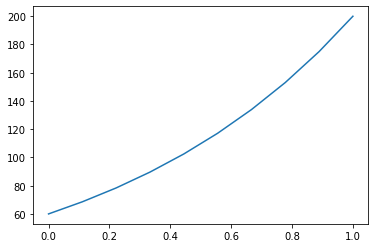

In [22]:
plt.plot(np.linspace(0,1,10), np.logspace(np.log(60), np.log(200), 10, base=np.exp(1)))
plt.show()

In [5]:
from configs.config import cfg
model = VQMotionModel(cfg.vqvae).cuda()

In [6]:
step = 220000
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/checkpoints/vqvae_motion.{step}.pt", map_location = 'cpu')
model.load_state_dict(pkg["model"])
model = model.cuda()
model = model.eval()

In [7]:
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total training params: %.2fM" % (total / 1e6))


Total training params: 151.57M


In [12]:
for name, param in model.motionEncoder.named_parameters():
    param.requires_grad = False
for name, param in model.motionDecoder.named_parameters():
    param.requires_grad = False

In [13]:
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total training params: %.2fM" % (total / 1e6))


Total training params: 0.00M


In [12]:
train_ds = VQVarLenMotionDataset("t2m", split = "test" , max_length_seconds = 10, data_root = "/srv/scratch/sanisetty3/music_motion/HumanML3D/HumanML3D")
collate_fn = MotionCollator()
train_loader = DATALoader(train_ds,
                                                1,
                                                #sampler=sampler,
                                                collate_fn=collate_fn,
                                                )

changing range to: 60 - 60


100%|██████████| 4384/4384 [00:02<00:00, 1572.07it/s]

Total number of motions 3980


In [41]:
for batch in train_loader:
    break
batch["motion"].shape

torch.Size([1, 147, 263])

In [326]:
from core.models.loss import ReConsLoss

loss_fnc = ReConsLoss("l1_smooth", 22)


In [13]:
losses =[]
losses_vel = []
with torch.no_grad():
    for batch in tqdm(train_loader):
        gt_motion = batch["motion"].cuda()
        pred_motion , indices, commit_loss = model(gt_motion)
        loss_motion = loss_fnc(pred_motion, gt_motion).detach().cpu()
        loss_vel = loss_fnc.forward_vel(pred_motion, gt_motion).detach().cpu()
#         loss = loss_motion.detach().cpu() + 0.02 * commit_loss + 0.5 * loss_vel.detach().cpu()
        losses.append(loss_motion)
        losses_vel.append(loss_vel)
    
print(np.mean(losses) , np.mean(losses_vel))

    

100%|██████████| 3980/3980 [01:38<00:00, 40.51it/s]


0.052648645 0.047441807


In [14]:
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768_aist/vqvae_motion.pt", map_location = 'cpu')


In [15]:
pkg.keys()

dict_keys(['model', 'optim', 'steps', 'total_loss'])

In [16]:
pkg["steps"]

tensor([200000.])

## Generating indices

In [4]:
from utils.motion_process import recover_from_ric
import visualize.plot_3d_global as plot_3d
from glob import glob
def to_xyz(motion, train_ds):
    motion_xyz = recover_from_ric(motion.cpu().float()*train_ds.std+train_ds.mean, 22)
    motion_xyz = motion_xyz.reshape(motion.shape[0],-1, 22, 3)
    return motion_xyz

            
def sample_render(motion_xyz , name , save_path):
    print(f"render start")
    
    gt_pose_vis = plot_3d.draw_to_batch(motion_xyz.numpy(),None, [os.path.join(save_path,name + ".gif")])



In [290]:
from configs.config import cfg, get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist.yaml")
model = VQMotionModel(cfg.vqvae).cuda()

In [343]:
step = 275000
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768_aist/checkpoints/vqvae_motion.{step}.pt", map_location = 'cpu')
model.load_state_dict(pkg["model"])
model = model.cuda()
model = model.eval()

In [ ]:
root = "/srv/scratch/sanisetty3/music_motion/AIST"

In [331]:
ind_ds = VQMotionDataset("aist", data_root = "/srv/scratch/sanisetty3/music_motion/AIST", split = "train", window_size = 1200)


100%|██████████| 1904/1904 [00:00<00:00, 2025.23it/s]

Total number of motions 1904


In [332]:
valid_dl = DATALoader(ind_ds , batch_size = 1, shuffle = False,collate_fn=None)


In [344]:
indices = []
motions = []
for batch in tqdm(valid_dl):
    ind = model.encode(batch["motion"].cuda())[0]
    motions.append(batch["motion"].cpu())
    indices.append(ind.detach().cpu().numpy())
    np.save(os.path.join("/srv/scratch/sanisetty3/music_motion/AIST", "joint_indices" ,batch["names"][0] + ".npy"), ind.detach().cpu().numpy())

100%|██████████| 1904/1904 [02:16<00:00, 13.92it/s]


In [337]:
indices[0].shape

torch.Size([239])

In [719]:
indx_list = glob("/srv/scratch/sanisetty3/music_motion/AIST/joint_indices/*.npy")

In [729]:
indices = np.load(indx_list[200])    
indices.shape

(239,)

In [730]:
quant , out_motion = model.decode(torch.LongTensor(indices[None,...]).cuda())
sample_render(to_xyz(out_motion[None,...].detach().cpu(), ind_ds), "rnd_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


In [727]:
sample_render(to_xyz(motions[-1].detach().cpu() , ind_ds), "rnd_og_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


In [350]:
losses =[]
losses_vel = []
with torch.no_grad():
    for batch in tqdm(valid_dl):
        gt_motion = batch["motion"].cuda()
        pred_motion , indices, commit_loss = model(gt_motion)
        loss_motion = loss_fnc(pred_motion, gt_motion).detach().cpu()
        loss_vel = loss_fnc.forward_vel(pred_motion, gt_motion).detach().cpu()
#         loss = loss_motion.detach().cpu() + 0.02 * commit_loss + 0.5 * loss_vel.detach().cpu()
        losses.append(loss_motion)
        losses_vel.append(loss_vel)
    
print(np.mean(losses) , np.mean(losses_vel))

    

100%|██████████| 1904/1904 [00:50<00:00, 37.74it/s]

0.06290357 0.03135447


In [5]:
from core.datasets.vqa_motion_dataset import VQVarLenMotionDatasetConditional,MotionCollatorConditional

In [6]:
ds = VQVarLenMotionDatasetConditional("aist", data_root = "/srv/scratch/sanisetty3/music_motion/AIST", split = "train", max_length_seconds = 60)


changing range to: 60 - 60


100%|██████████| 1904/1904 [00:04<00:00, 434.01it/s]

Total number of motions 1904


In [7]:
motionCollator = MotionCollatorConditional(dataset_name = "aist" , bos = 1024 , pad = 1025, eos = 1026)
dl = DATALoader(ds , batch_size = 4, shuffle = False,collate_fn=motionCollator)


In [8]:
dl.dataset.set_stage(4)

changing range to: 60 - 228


In [9]:
for batch in dl:
    break

In [597]:
x = batch["motion"]
inp, target = x[:, :-1], x[:, 1:]
seq = x.shape[1]

In [16]:
from configs.config import cfg
from core.models.motion_regressor import MotionRegressorModel
motreg = MotionRegressorModel(args = cfg.motion_trans , ignore_index=1025 ,pad_value=1025 )

In [22]:
start_tokens = torch.LongTensor([1024]).reshape(1,1)

In [30]:
batch["condition"].shape

torch.Size([4, 174, 128])

In [25]:
batch.keys()

dict_keys(['motion', 'motion_lengths', 'motion_mask', 'names', 'condition', 'condition_mask'])

In [32]:
motion = motreg.generate(start_tokens = start_tokens, seq_len=100 , context = batch["condition"][0:1], context_mask = batch["condition_mask"][0:1])

100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


In [715]:
out = motreg(motion = batch["motion"] , mask = batch["motion_mask"] , context = batch["condition"], context_mask = batch["condition_mask"])

torch.Size([])


In [658]:
inp, targets = batch["motion"][:, :-1], batch["motion"][:, 1:]

In [661]:
targets.contiguous().view(-1).shape

torch.Size([896])

In [667]:
torch.randn((4, 224 , 1027)).contiguous().view(-1, 1027).shape

torch.Size([896, 1027])

In [708]:
loss = F.cross_entropy(torch.randn((4, 224 , 1027)).contiguous().view(-1, 1027), targets.contiguous().view(-1),
            ignore_index=1025, reduction='none').reshape(4,-1)

In [709]:
loss.shape

torch.Size([4, 224])

In [713]:
torch.sum(batch["motion_mask"][:,:-1] , -1)


tensor([224, 169, 157, 197])

In [ ]:
torch.sum()

In [555]:
cond_mask = ~(x[x!=1026].view(x.shape[0] , -1)[:,1:] == 1025)

In [556]:
cond_mask.shape

torch.Size([4, 145])

In [551]:
motion_mask.shape

torch.Size([4, 147])

In [522]:
batch["condition"]

torch.Size([4, 145, 128])

In [517]:
sum(mask[0]*batch["motion_mask"][0, :-1])

tensor(64)

In [ ]:
dots = dots.masked_fill(max_attend_past_mask, mask_value)

In [509]:
tok_emb = TokenEmbedding2(768 , 1026 , pad_idx = 1)

In [511]:
tok_emb(inp).shape

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [221]:
out = motionDecoder(x = inp, mask = batch["motion_mask"][:,:-1] , context = batch["condition"][:,:-1] , context_mask = batch["motion_mask"][:,:-1])

torch.Size([4, 178, 768]) torch.Size([4, 178, 768]) torch.Size([4, 178]) torch.Size([4, 178])


In [276]:
out

torch.Size([4, 178, 1026])

In [142]:
out = out.transpose(1, 2)

In [143]:
out.shape

torch.Size([4, 1026, 178])

In [223]:
target.shape

torch.Size([4, 178])

In [497]:
loss = F.cross_entropy(
            out.reshape(-1,1026),
            target.reshape(-1),
            ignore_index = 1,
            reduction = "none"
    
        )

RuntimeError: shape '[-1, 1026]' is invalid for input of size 20

In [226]:
loss

tensor(7.1186, grad_fn=<NllLossBackward0>)

## Cross attention

In [566]:
q = torch.randn((5,4))
k = torch.randn((5,4))
v = torch.randn((5,4))

In [463]:
q

tensor([[ 1.2023,  0.6955, -2.4969, -0.7475],
        [-0.6933,  0.3138,  1.3367,  2.4379],
        [-0.2542, -1.2591, -0.0520,  0.8134],
        [-1.9622,  0.7228, -0.9052, -0.2472],
        [ 0.3010,  0.8481,  1.4993, -0.5711]])

In [464]:
k

tensor([[-1.0769,  0.0516,  1.2195, -0.1094],
        [-1.7388,  0.1488,  1.7214,  0.8309],
        [-0.2944, -0.4466, -0.3187,  0.0227]])

In [565]:
mask = torch.BoolTensor([1,1,1,1,0])
context_mask = torch.BoolTensor([0,1,1,0,0])

In [567]:
dots = torch.einsum(f'i d, j d -> i j', q, k) 

In [568]:
dots.shape

torch.Size([5, 5])

In [569]:
input_mask = rearrange(context_mask, 'j -> 1 j')
dots = dots.masked_fill(~input_mask, -torch.finfo(dots.dtype).max)

In [570]:
dots

tensor([[-3.4028e+38, -1.9609e+00,  1.0935e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  3.3129e+00, -4.9215e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  2.5482e+00, -1.2629e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38, -4.5168e+00,  2.2125e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  5.8091e+00, -3.9529e+00, -3.4028e+38, -3.4028e+38]])

In [571]:
i, j = dots.shape[-2:]
causal_mask = torch.ones((i, j), dtype = torch.bool).triu(j - i + 1)
dots = dots.masked_fill(causal_mask, -torch.finfo(dots.dtype).max)

In [572]:
dots

tensor([[-3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  3.3129e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  2.5482e+00, -1.2629e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38, -4.5168e+00,  2.2125e+00, -3.4028e+38, -3.4028e+38],
        [-3.4028e+38,  5.8091e+00, -3.9529e+00, -3.4028e+38, -3.4028e+38]])

In [573]:
attn = F.softmax(dots , dim = -1)

In [576]:
attn

tensor([[2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-01],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.7836e-01, 2.1644e-02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1939e-03, 9.9881e-01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.9994e-01, 5.7596e-05, 0.0000e+00, 0.0000e+00]])

In [574]:
out = torch.einsum(f'i j, j d-> i d', attn, v)

In [575]:
out.shape

torch.Size([5, 4])